In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

In [ ]:
lattice_spacing = 5.64e-10
l_cuka = 1.54e-10
l_cukb = 1.39e-10

In [ ]:
def gauss(x, A, x0, sigma):
    return A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

def fit_gaussian(x, y, p0):
    popt, pcov = curve_fit(gauss, x, y, p0)
    return popt[1], popt[2]

In [ ]:
def potential_match(theta, delta_theta):
    a = 5.64e-10
    potential_matches = []
    for h in range(5):
        for k in range(5):
            for l in range(5):
                for wavelength in [1.54e-10, 1.39e-10]:
                    for order in [1, 2]:
                        if abs(order * wavelength / 2 * np.sqrt(h ** 2 + k ** 2 + l ** 2) / a) < 1:
                            theta_thy = np.degrees(np.arcsin(order * wavelength / 2 * np.sqrt(h ** 2 + k ** 2 + l ** 2) / a))
                        else:
                            theta_thy = -100000
                        if abs(theta_thy - theta) < delta_theta:
                            potential_matches.append(
                                (order, f'{h, k, l}', wavelength * 1e10)
                            )                    
    return potential_matches

In [ ]:
columns = ['theta2', 'intensity']
nacl_powder = pd.read_csv('data/NaCl_powder.tsv', sep='\t', skiprows=1, encoding='unicode_escape')
nacl_powder.columns = columns

Text(0.5, 1.0, 'NaCl Powder Diffraction')

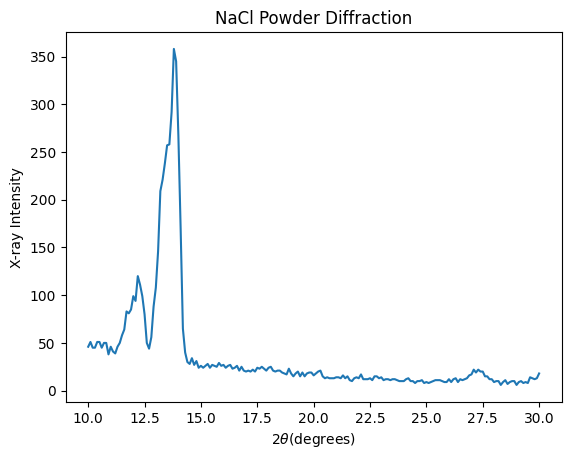

In [ ]:
plt.plot(
    nacl_powder.theta2,
    nacl_powder.intensity
)

plt.xlabel(r'$2\theta$(degrees)')
plt.ylabel('X-ray Intensity')
plt.title('NaCl Powder Diffraction')

In [ ]:
sample = nacl_powder
def extract_peak(peak, lower, upper):
    data = sample[(sample["theta2"] >= lower) & (sample["theta2"] <= upper)]
    mu, sigma = fit_gaussian(data["theta2"], data["intensity"], [500, (lower + upper) / 2, 1])
    return pd.Series({
        "peak": peak,
        "theta": mu / 2,
        "d_theta": sigma / 2,
        "potential_matches": potential_match(mu / 2, sigma / 2)
    })

In [ ]:
extract_peak(1, 10, 12.9)

peak                                                                 1
theta                                                         6.225915
d_theta                                                       0.896948
potential_matches    [(1, (0, 0, 1), 1.3900000000000001), (1, (0, 1...
dtype: object

In [ ]:
extract_peak(2, 12.9, 15)

peak                        2
theta                6.825559
d_theta              0.206991
potential_matches          []
dtype: object

In [ ]:
powder = pd.DataFrame(columns=['peak','theta', 'd_theta', 'potential_matches'])

In [ ]:
powder.__append(extract_peak(1, 12.9, 15))

AttributeError: 'DataFrame' object has no attribute '__append'